# Test of MoGe and SAM2

### Imports

In [ ]:
import os

import numpy as np
import cv2 as cv
import torch
import matplotlib.pyplot as plt
from PIL import Image

import open3d as o3d
from trimesh import Trimesh

from moge.model.v2 import MoGeModel
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from superprimitive_fusion.utils import (get_integer_segments,
                   plot_region_numbers,
                   triangulate_segments,
                   smooth_mask,
                   show_anns,
                   crop_by_SP,
                   fill_ring_holes,
                   trimesh_to_o3d)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Define devices and functions

In [2]:
device0 = torch.device("cuda:0")
device1 = torch.device("cuda:1")

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Load models

In [3]:
sam2_checkpoint = "../models/SAM2/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device0, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [4]:
moge_model = MoGeModel.from_pretrained("../models/MoGe/moge-2-vitl-normal.pt").to(device0)

### Add input image

In [5]:
# Read the input image and convert to tensor (3, H, W) with RGB values normalized to [0, 1]
input_image = cv.cvtColor(cv.imread("../data/mustard360/images/frame_0.png"), cv.COLOR_BGR2RGB)                       
input_image_tensor = torch.tensor(input_image / 255, dtype=torch.float32, device=device0).permute(2, 0, 1)
input_image_array  = np.array(input_image)

### Infer segmentation masks and estimate geometry

In [6]:
masks = mask_generator.generate(input_image_array)

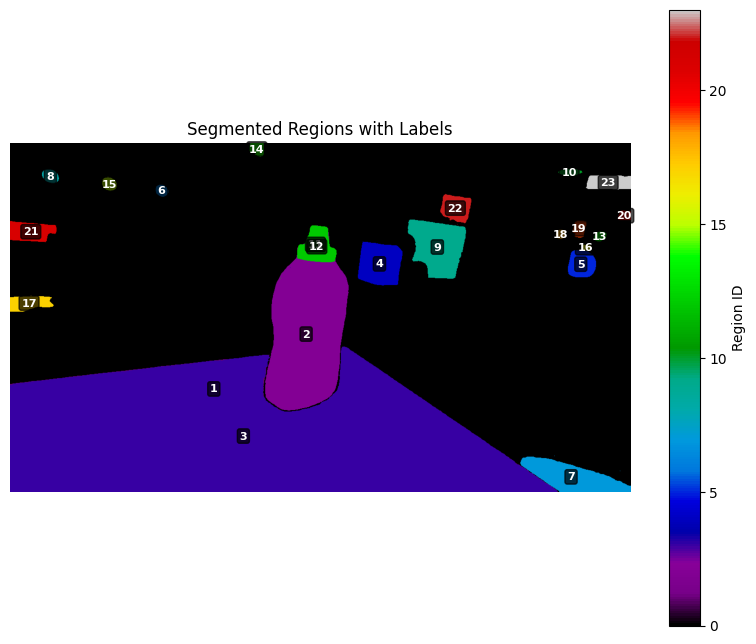

In [7]:
segmentation_masks = [mask['segmentation'] for mask in masks]
segmentation_masks = np.array(segmentation_masks)

int_seg = get_integer_segments(segmentation_masks)
plot_region_numbers(int_seg)

In [8]:
output = moge_model.infer(input_image_tensor)
"""
`output` has keys "points", "depth", "mask", "normal" (optional) and "intrinsics",
The maps are in the same size as the input image. 
{
    "points": (H, W, 3),    # point map in OpenCV camera coordinate system (x right, y down, z forward). For MoGe-2, the point map is in metric scale.
    "depth": (H, W),        # depth map
    "normal": (H, W, 3)     # normal map in OpenCV camera coordinate system. (available for MoGe-2-normal)
    "mask": (H, W),         # a binary mask for valid pixels. 
    "intrinsics": (3, 3),   # normalized camera intrinsics
}
"""

'\n`output` has keys "points", "depth", "mask", "normal" (optional) and "intrinsics",\nThe maps are in the same size as the input image. \n{\n    "points": (H, W, 3),    # point map in OpenCV camera coordinate system (x right, y down, z forward). For MoGe-2, the point map is in metric scale.\n    "depth": (H, W),        # depth map\n    "normal": (H, W, 3)     # normal map in OpenCV camera coordinate system. (available for MoGe-2-normal)\n    "mask": (H, W),         # a binary mask for valid pixels. \n    "intrinsics": (3, 3),   # normalized camera intrinsics\n}\n'

### Show outputs

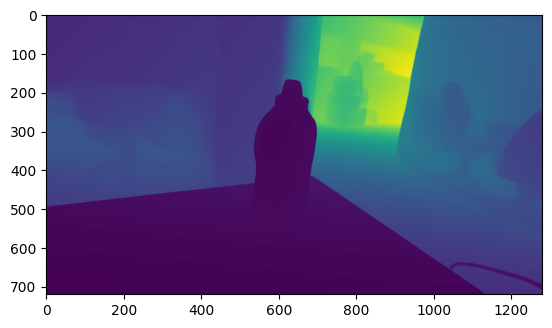

In [9]:
plt.imshow(output["depth"].cpu())

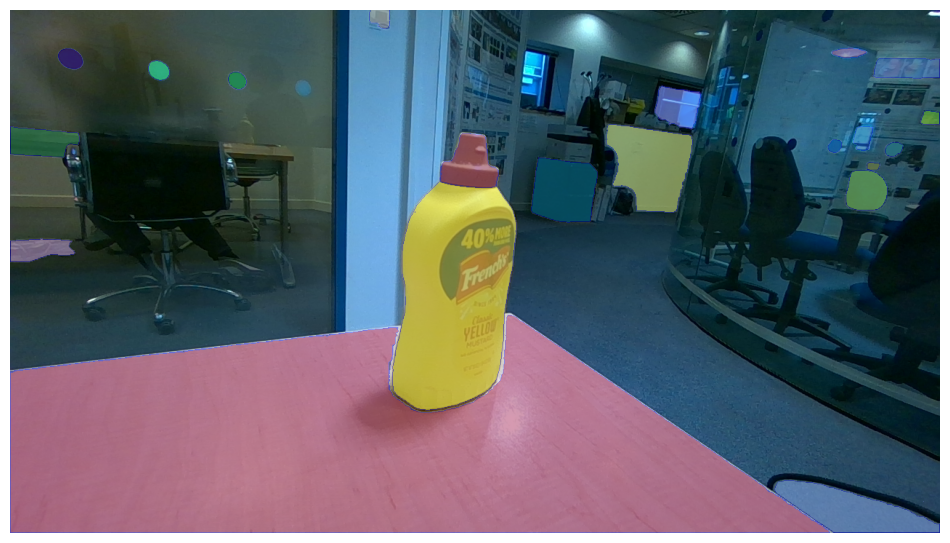

In [10]:
plt.figure(figsize=(12,12))
plt.imshow(input_image_array)
show_anns(masks)
plt.axis('off')
plt.show() 

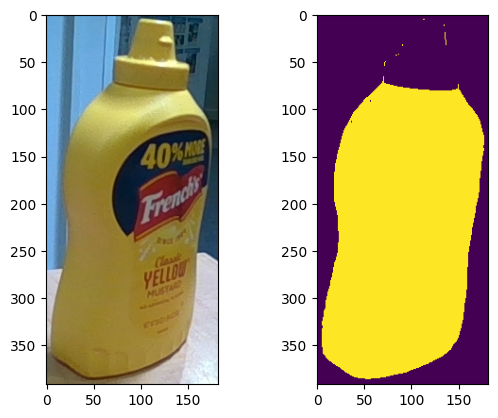

In [11]:
points = output['points'].cpu().numpy()
int_seg_cropped, img_cropped, points_cropped = crop_by_SP(2, int_seg, input_image, points, border=5, make_binary=True)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_cropped)
axarr[1].imshow(int_seg_cropped)

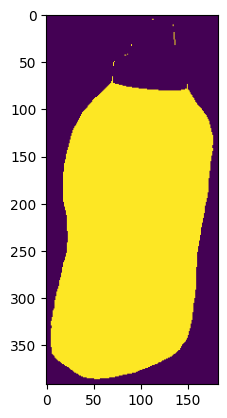

In [12]:
filled_int_seg = fill_ring_holes(int_seg_cropped, radius=2)
plt.imshow(filled_int_seg)

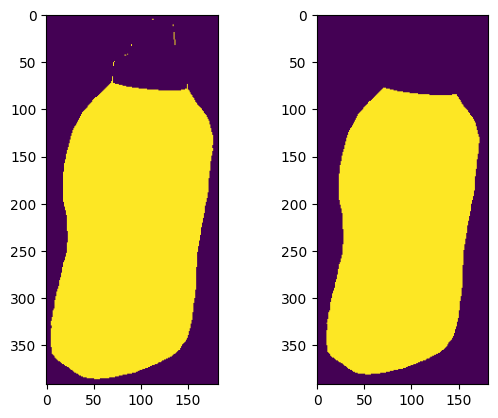

In [13]:
int_seg_smoothed = smooth_mask(filled_int_seg, radius_erode=5, radius_dilate=None)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(filled_int_seg)
axarr[1].imshow(int_seg_smoothed)

In [14]:
colours_cropped = np.clip(img_cropped, 0, 255).reshape((-1,3)).astype(np.uint8, casting='unsafe')
alpha_channel = 255*np.ones((np.prod(img_cropped.shape[:2]),1), dtype=np.uint8)
colours_cropped = np.hstack([colours_cropped, alpha_channel])

verts_cropped = points_cropped.reshape((-1,3))

In [ ]:
tris = triangulate_segments(verts_cropped, int_seg_smoothed)

In [16]:
all_tris = [tri for trise in tris for tri in trise]
mesh = Trimesh(vertices=verts_cropped, faces=all_tris, vertex_colors=colours_cropped)
meshes = [Trimesh(vertices=verts_cropped, faces=individual_tris, vertex_colors=colours_cropped) for individual_tris in tris]

In [17]:
mesh.show()

In [18]:
mesh_filtered_o3d = trimesh_to_o3d(mesh)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_cropped[int_seg_smoothed != 0])
pcd.colors = o3d.utility.Vector3dVector(np.zeros((len(pcd.points),3)))

o3d.visualization.draw_geometries([mesh_filtered_o3d, pcd])